# 12/28/23 - This notebook tests the module "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/total_mass_mge.py
## I'm trying to determine how the mass is producing the wrong kinematic profile.

In [16]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# jampy
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [121]:
constants.pc

<<class 'astropy.constants.iau2015.IAU2015'> name='Parsec' value=3.085677581491367e+16 uncertainty=0.0 unit='m' reference='Derived from au + IAU 2015 Resolution B 2 note [4]'>

In [120]:
u.M_sun

Unit("solMass")

In [122]:
constants.c **2 / constants.G / 4 / np.pi * (u.M_sun / constants.M_sun) * (constants.pc / u.pc)

<Quantity 1.66291654e+12 solMass / pc>

In [123]:
c2_4piG

<Quantity 1.66291654e+12 solMass / pc>

In [2]:
# bring in the total_mass_mge module

from total_mass_mge import total_mass_mge

In [3]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
#zlenses = slacs_ix_table['z_lens']
#zsources = slacs_ix_table['z_src']

In [4]:
###############################################################################

# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, cov_matrix, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.cov_matrix=cov_matrix
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
        
###############################################################################


def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy_with_cov.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    try:
        dVrms_bin = tommy_pickles.dVrms_bin 
    except:
        dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    try: 
        cov_matrix = tommy_pickles.cov_matrix
    except:
        cov_matrix=1
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, cov_matrix, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [5]:
# get all the info for one of the objects

obj_name = obj_names[1] # j0037
SN = 15
file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'

surf, sigma, qobs,  \
    kcwi_sigmapsf, Vrms, dVrms, \
    cov_matrix, V_bin, dV_bin, \
    xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)

In [70]:
# lens model power law info

lens_models_chinyi = pd.read_csv(f'{tables_dir}lens_models_table_chinyi.csv')
lens_models_chinyi_sys = pd.read_csv(f'{tables_dir}lens_models_table_chinyi_with_sys.csv')
lens_models_anowar = pd.read_csv(f'{tables_dir}lens_models_table_anowar.csv')

In [86]:
# set up reasonable mass parameters

zlens = slacs_ix_table[slacs_ix_table['Name']==obj_name]['z_lens']
zsource = slacs_ix_table[slacs_ix_table['Name']==obj_name]['z_src']
gamma = lens_models_chinyi_sys[lens_models_chinyi_sys['obj_name']==obj_name]['gamma'].values[0]
f_dm = 0
theta_E = lens_models_chinyi_sys[lens_models_chinyi_sys['obj_name']==obj_name]['theta_E'].values[0]
k_mst = 0.8
a_mst = 7
lambda_int = 1.0

# Get the effective shape and (not) effective radius from the half-light isophote
_, _, eps_eff, _ = mge_half_light_isophote(surf, sigma, qobs)
qobs_eff = 1-eps_eff

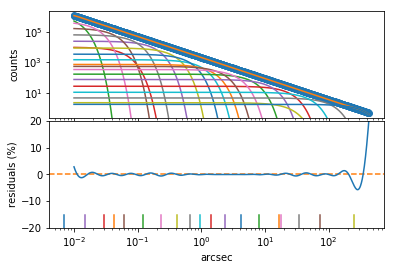

In [87]:
# get total mass profile
break_factor=200

total_mass = total_mass_mge(surf, sigma, qobs, 'power_law', qobs_eff, reff, break_factor, zlens, zsource, cosmo,
                           gamma, f_dm, theta_E, k_mst, a_mst, lambda_int, plot=True)

In [88]:
c2_4piG

<Quantity 1.66291654e+12 solMass / pc>

In [111]:
# jam to get velocity

inc=90
mbh=0
distance = cosmo.angular_diameter_distance(zlens).value
beta = np.ones_like(surf)*0.1




jam_zz =  jam_axi_proj(surf_lum=surf, sigma_lum=sigma, qobs_lum=qobs,
            surf_pot=total_mass.surf_pot/2, sigma_pot=total_mass.sigma_pot, qobs_pot=total_mass.qobs_pot,
            inc=inc, mbh=mbh, distance=distance,
            xbin=xbin.ravel(), ybin=ybin.ravel(), align='sph',
            beta=beta, moment='zz', pixsize=0.1457,
            sigmapsf=kcwi_sigmapsf, plot=True)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.62
analytic_los=0 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.10; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.948e+11



In [112]:
total_mass.sigma_pot

array([7.07106781e-03, 1.46330915e-02, 2.92055344e-02, 4.22312277e-02,
       6.10384552e-02, 1.23057244e-01, 2.35236282e-01, 4.11152096e-01,
       6.56253309e-01, 9.61816871e-01, 1.41001075e+00, 2.33662769e+00,
       4.21848230e+00, 8.14327560e+00, 1.64862901e+01, 1.77133981e+01,
       3.38424224e+01, 7.40110795e+01, 2.46093876e+02])

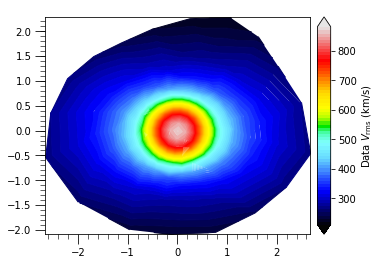

In [113]:
vel_field = jam_zz.model

plot_velfield(xbin, ybin, vel_field, vmin=np.min(jam_zz.model)-10, vmax=np.max(jam_zz.model)+10, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", nodots=True) ;


In [114]:
np.mean(vel_field)

490.6538287056615

In [126]:
# Check the distances
DL = cosmo.angular_diameter_distance(zlens).to('pc')
DS = cosmo.angular_diameter_distance(zsource).to('pc')
DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to('pc')

In [132]:
sigma_crit = DS / (DL * DLS) * c2_4piG

In [133]:
sigma_crit

<Quantity [3811.34885867] solMass / pc2>

In [149]:
surface_mass_density = sigma_crit.value * total_mass.kappa_int

In [150]:
# integrate over it

In [151]:
from scipy.integrate import quad

In [158]:
def integrand (r):
    return surface_mass_density[total_mass.r==r] * r

In [159]:
2*np.pi * quad(integrand, 0, 200*reff)

TypeError: only size-1 arrays can be converted to Python scalars

array([1.00000000e-02, 1.01072800e-02, 1.02157108e-02, 1.03253050e-02,
       1.04360748e-02, 1.05480330e-02, 1.06611922e-02, 1.07755655e-02,
       1.08911657e-02, 1.10080061e-02, 1.11261000e-02, 1.12454607e-02,
       1.13661020e-02, 1.14880375e-02, 1.16112811e-02, 1.17358469e-02,
       1.18617490e-02, 1.19890019e-02, 1.21176198e-02, 1.22476176e-02,
       1.23790100e-02, 1.25118120e-02, 1.26460387e-02, 1.27817054e-02,
       1.29188274e-02, 1.30574206e-02, 1.31975006e-02, 1.33390833e-02,
       1.34821849e-02, 1.36268218e-02, 1.37730103e-02, 1.39207671e-02,
       1.40701090e-02, 1.42210531e-02, 1.43736165e-02, 1.45278167e-02,
       1.46836710e-02, 1.48411974e-02, 1.50004137e-02, 1.51613381e-02,
       1.53239889e-02, 1.54883846e-02, 1.56545440e-02, 1.58224859e-02,
       1.59922294e-02, 1.61637940e-02, 1.63371992e-02, 1.65124646e-02,
       1.66896103e-02, 1.68686563e-02, 1.70496232e-02, 1.72325315e-02,
       1.74174021e-02, 1.76042559e-02, 1.77931143e-02, 1.79839988e-02,
      